In [0]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.optimizers import Adam
from keras import initializers
from keras.utils import plot_model, np_utils
from keras import backend as K
from SpectralNormalizationKeras import DenseSN, ConvSN2D, ConvSN2DTranspose

Using TensorFlow backend.


In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 14s 0us/step


In [5]:
num_classes = len(np.unique(y_train))
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
    X_test = X_test.reshape(X_test.shape[0], 3, 32, 32)
    input_shape = (3, 32, 32)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)
    
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_test / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

print('X_train reshape:', X_train.shape)
print('X_test reshape:', X_test.shape)

X_train reshape: (50000, 32, 32, 3)
X_test reshape: (10000, 32, 32, 3)


In [0]:
img_shape = X_train[0].shape
init = initializers.RandomNormal(stddev=0.02)
latent_dim = 100

In [0]:
def get_DC_generator_SN(latent_dim, init):
    model = Sequential([
        DenseSN(2*2*512, input_shape=(latent_dim,), kernel_initializer=init),
        Reshape((2, 2, 512)),
        BatchNormalization(),
        LeakyReLU(0.2),
        ConvSN2DTranspose(256, kernel_size=5, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(0.2),
        ConvSN2DTranspose(128, kernel_size=5, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(0.2),
        ConvSN2DTranspose(64, kernel_size=5, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(0.2),
        ConvSN2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh')
    ])
    print("Generator Model Summary")
    print(model.summary())
    return model

In [0]:
def get_DC_discriminator_SN(img_shape, init):
    model = Sequential([
        ConvSN2D(64, kernel_size=5, strides=2, padding='same', input_shape=(img_shape), kernel_initializer=init),
        LeakyReLU(0.2),
        ConvSN2D(128, kernel_size=5, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(0.2),
        ConvSN2D(256, kernel_size=5, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(0.2),
        ConvSN2D(512, kernel_size=5, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(0.2),
        Flatten(),
        DenseSN(1, activation='sigmoid')
    ])
    print("Discriminator Model Summary")
    print(model.summary())
    return model

In [9]:
pip install tensorflow-gan

     |████████████████████████████████| 368kB 12.1MB/s 


In [10]:
import tensorflow_gan as tfgan
def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    fid = tfgan.eval.frechet_classifier_distance_from_activations(act1, act2)
    return fid

In [0]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true*y_pred)

In [38]:
DC_generator = get_DC_generator_SN(latent_dim, init)
DC_discriminator = get_DC_discriminator_SN(img_shape, init)
DC_discriminator.compile(Adam(lr=0.0003, beta_1=0.5), loss='binary_crossentropy', metrics=['binary_accuracy'])

Generator Model Summary
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_sn_3 (DenseSN)         (None, 2048)              208896    
_________________________________________________________________
reshape_2 (Reshape)          (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 2, 2, 512)         2048      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 2, 2, 512)         0         
_________________________________________________________________
conv_s_n2d_transpose_5 (Conv (None, 4, 4, 256)         3277568   
_________________________________________________________________
batch_normalization_9 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (

In [0]:
DC_generator.load_weights('./models/DC_generator_model_400_ep.h5')
DC_discriminator.load_weights('./models/DC_discriminator_model_400_ep.h5')

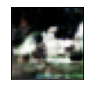

In [41]:
x_fake = DC_generator.predict(np.random.normal(loc=0, scale=1, size=(1, latent_dim)))
for k in range(1):
    plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
    plt.imshow(((x_fake[k] + 1)* 127).astype(np.uint8))

plt.tight_layout()
plt.show()

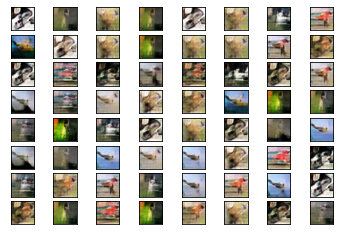

In [42]:
samples = 64
x_fake = DC_generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

for k in range(samples//8):
    for it in range(8):
        plt.subplot(8,8, k*8 + it + 1, xticks=[], yticks=[])
        plt.imshow(((x_fake[k*8 + it] + 1)* 127).astype(np.uint8))

#plt.tight_layout()
plt.show()